In [1]:
# Importation des librairies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error
from sklearn.svm import OneClassSVM
from pandas_profiling import ProfileReport

In [2]:
# Configuration des paramètres
n_samples = 20
outliers_fraction = 0.25

In [3]:
# Chargement du fichier csv
data = pd.read_csv("AG000060590.csv")

In [29]:
prof = ProfileReport(data)
prof.to_file(output_file='rapport.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


In [4]:
# Mise en forme des colonnes concernées
data['TAVG'] = StandardScaler().fit_transform(data['TAVG'].values.reshape(-1,1))
data['TMIN'] = StandardScaler().fit_transform(data['TMIN'].values.reshape(-1,1))
data['TMAX'] = StandardScaler().fit_transform(data['TMAX'].values.reshape(-1,1))
data['TAVG'] = data['TAVG'].fillna(0)
data['TMIN'] = data['TMIN'].fillna(0)
data['TMAX'] = data['TMAX'].fillna(0)

In [5]:
#Filtrage des données à récupérer
years = data['DATE']  
X = data['TAVG'] 
y = data.drop(['STATION','LATITUDE','LONGITUDE','ELEVATION','NAME','CDSD','CDSD_ATTRIBUTES','CLDD','CLDD_ATTRIBUTES','DP01','DP01_ATTRIBUTES','DP10','DP10_ATTRIBUTES','DP1X','DP1X_ATTRIBUTES','DT00','DT00_ATTRIBUTES','DT32','DT32_ATTRIBUTES','DX32','DX32_ATTRIBUTES','DX70','DX70_ATTRIBUTES','DX90','DX90_ATTRIBUTES','EMNT','EMNT_ATTRIBUTES','EMXP','EMXP_ATTRIBUTES','EMXT','EMXT_ATTRIBUTES','FZF0','FZF0_ATTRIBUTES','FZF1','FZF1_ATTRIBUTES','FZF2','FZF2_ATTRIBUTES','FZF5','FZF5_ATTRIBUTES','FZF6','FZF6_ATTRIBUTES','FZF7','FZF7_ATTRIBUTES','FZF8','FZF8_ATTRIBUTES','HDSD','HDSD_ATTRIBUTES','HTDD','HTDD_ATTRIBUTES','PRCP','PRCP_ATTRIBUTES','TAVG_ATTRIBUTES','TMAX_ATTRIBUTES','TMIN_ATTRIBUTES','DATE','TAVG'], axis=1) 

In [6]:
#Séparation des données pour les entrainements et les tests
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state=42 )

In [7]:
# Préparation du outlier
ee = OneClassSVM(nu=0.01)
y_result = ee.fit_predict(y_train)

mae = mean_absolute_error(X_train, y_result)
print(mae)

1.209283168814208


In [8]:
# Préparation du dataset des années
chrono = np.array([[0, 0]])

chrono = np.delete(chrono, 0, 0)
for x in range(len(data)):
    chrono = np.append(chrono, [[x, years[x]]], axis = 0)

In [9]:
# Préparation du dataset des moyennes annuelles
moyenne = np.array([[0, 0]])

moyenne = np.delete(moyenne, 0, 0)
for y in range(len(data)):
    moyenne = np.append(moyenne, [[y, X[y]]], axis = 0)

In [10]:
# Répartition des moyennes annuelles en fonction de la reconaissance des valeurs normales ou anormales
valeur_normales = np.array([[0, 0]])
valeur_anormales = np.array([[0, 0]])

valeur_normales = np.delete(valeur_normales, 0, 0)
valeur_anormales = np.delete(valeur_anormales, 0, 0) 

for i in range(len(chrono)):
    if ((moyenne[i][1] < 0 and moyenne[i][1] >= -mae) or (moyenne[i][1] > 0 and moyenne[i][1] <= mae)):
        valeur_normales = np.append(valeur_normales, [[chrono[i][1], moyenne[i][1]]], axis = 0)
        valeur_anormales = np.append(valeur_anormales, [[chrono[i][1], 1000]], axis = 0)
    else:
        if (moyenne[i][1] == 0):
            valeur_anormales = np.append(valeur_anormales, [[chrono[i][1], 1000]], axis = 0)
        else:
            valeur_anormales = np.append(valeur_anormales, [[chrono[i][1], moyenne[i][1]]], axis = 0)
        valeur_normales = np.append(valeur_normales, [[chrono[i][1], 1000]], axis = 0)

(-3.627849506442624, 3.627849506442624)

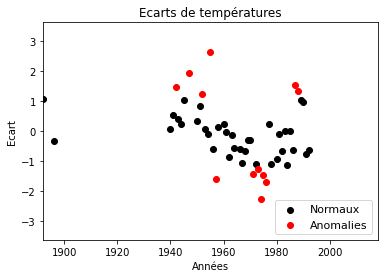

In [11]:
# Affichage du graphique représentant les valeurs
a = plt.scatter(chrono[:len(X_train), 1], valeur_normales[:len(X_train), 1], c='black')
b = plt.scatter(chrono[:len(X_train), 1], valeur_anormales[:len(X_train), 1], c='red')
plt.ylim(-mae * 2, mae * 2)
plt.legend(
    [a,b],
    ['Normaux','Anomalies'],
    prop=matplotlib.font_manager.FontProperties(size=11),
    loc='lower right')
plt.title('Ecarts de températures')
plt.xlabel('Années')
plt.ylabel('Ecart')
plt.xlim(years.values.min(), years.values.max())
plt.ylim(-mae * 3, mae * 3)